In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from IPython.display import display, HTML

# Download data

In [478]:
import json
import os

with open('./kaggle.json') as json_file:
    data = json.load(json_file)
    kaggle_username = data['username']
    api_key = data['key']
    os.environ['KAGGLE_USERNAME'] = kaggle_username
    os.environ['KAGGLE_KEY'] = api_key
    !kaggle competitions download -c sberbank-russian-housing-market

100%|███████████████████████████████████████| 21.6M/21.6M [00:59<00:00, 349kB/s]
100%|███████████████████████████████████████| 21.6M/21.6M [00:59<00:00, 380kB/s]


In [479]:
!unzip -o sberbank-russian-housing-market.zip
!rm sberbank-russian-housing-market.zip
!rm -r sample_data
!unzip -o train.csv.zip
!rm train.csv.zip
!unzip -o macro.csv.zip
!rm macro.csv.zip
!unzip -o sample_submission.csv.zip
!rm sample_submission.csv.zip
!unzip -o test.csv.zip
!rm test.csv.zip
!rm -r __MACOSX

Archive:  sberbank-russian-housing-market.zip
  inflating: data_dictionary.txt     
  inflating: macro.csv.zip           
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           
rm: невозможно удалить 'sample_data': Нет такого файла или каталога
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  macro.csv.zip
  inflating: macro.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     


In [480]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')
train['timestamp'] = train['timestamp'].apply(pd.to_datetime)

In [481]:
def num_houses_with_bigger_column_value (column_name, value):
    return len(train[train[column_name] > value].index)

def num_houses_with_less_column_value (column_name, value):
    return len(train[train[column_name] < value].index)

In [482]:
def plot_feature_kde(column_name, min_value, max_value):
    data = train[column_name]
    data = data.where(data.notnull(), axis=0)
    data = data[(min_value <= data) & (data <= max_value)]
    ax = sns.kdeplot(data=data, shade=True)
    ax.set(xlabel= column_name, ylabel='density')

def plot_regplot(column_name1, column_name2, col1_min, col1_max, col2_min, col2_max, alpha=0.1):
    reg_plot_data = train[[column_name1, column_name2]]
    reg_plot_data = reg_plot_data[(col1_min <= train[column_name1]) & (train[column_name1] <= col1_max) \
                                & (col2_min <= train[column_name2]) & (train[column_name2] <= col2_max)]
    sns.regplot(x=reg_plot_data[column_name1], y=reg_plot_data[column_name2], \
              scatter_kws={'alpha':alpha})

def plot_features_jointplot(column_name1, column_name2, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2]]
    data = data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
                  & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.jointplot(column_name1, column_name2, data=data, kind="kde", space=0, color="b", \
                scatter_kws={'alpha':alpha})

def plot_lmplot(column_name1, column_name2, hue, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2, hue]]
    data = data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.lmplot(x=column_name1, y=column_name2, hue=hue, data=data, scatter_kws={'alpha':alpha})

def plot_distplot(column_name):
      sns.distplot(a=train[column_name], kde=False)

# Understanding missing values

In [483]:
numeric_nan_info = train._get_numeric_data().isna().sum()
print(len(numeric_nan_info[numeric_nan_info > 0]), 'numeric columns have missing values.\n')
numeric_nan_info[numeric_nan_info > 0]

51 numeric columns have missing values.



life_sq                                   6383
floor                                      167
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
preschool_quota                           6688
school_quota                              6685
hospital_beds_raion                      14441
raion_build_count_with_material_info      4991
build_count_block                         4991
build_count_wood                          4991
build_count_frame                         4991
build_count_brick                         4991
build_count_monolith                      4991
build_count_panel                         4991
build_count_foam                          4991
build_count_slag                          4991
build_count_mix                           4991
raion_build_c

In [484]:
numeric_features = train._get_numeric_data().columns
categorical_features = set(train.columns) - set(numeric_features)
categorical_features_nan_info = train[categorical_features].isna().sum()
print(len(categorical_features_nan_info[categorical_features_nan_info > 0]), \
      'categorical columns have missing values.\n')
categorical_features_nan_info[categorical_features_nan_info > 0]

0 categorical columns have missing values.



Series([], dtype: int64)

In [485]:
train.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,3.047100e+04,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,1.765705e+07,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,2.064961e+07,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,2.081628e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,7.307411e+06,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,1.050803e+07,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,1.803644e+07,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,2.060718e+08,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


In [486]:
heatmap_df = train.iloc[:, 1:9].copy()
heatmap_df.dropna(inplace=True)
heatmap_df.corr()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq
full_sq,1.000000,0.254972,0.160772,0.208166,0.050752,-0.006065,0.713927,0.042118
life_sq,0.254972,1.000000,0.034216,0.043237,0.010481,-0.002401,0.187473,0.002555
floor,0.160772,0.034216,1.000000,0.535355,0.028114,0.001426,0.003288,0.008220
max_floor,0.208166,0.043237,0.535355,1.000000,0.071513,-0.000283,-0.006762,0.040285
material,0.050752,0.010481,0.028114,0.071513,1.000000,-0.004606,-0.040406,0.033845
build_year,-0.006065,-0.002401,0.001426,-0.000283,-0.004606,1.000000,-0.008501,0.000490
num_room,0.713927,0.187473,0.003288,-0.006762,-0.040406,-0.008501,1.000000,0.016216
kitch_sq,0.042118,0.002555,0.008220,0.040285,0.033845,0.000490,0.016216,1.000000


# &emsp; full_sq

The plan for this section is to understand full_sq's interaction with other features and understand how he can fill NANs knowing feture interactions.

In [487]:
train['full_sq'].describe()

count    30471.000000
mean        54.214269
std         38.031487
min          0.000000
25%         38.000000
50%         49.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64

In [488]:
# these values are obviously unnecessary in our future analysis
train.drop(train[train['full_sq'] > 1000].index, inplace=True)

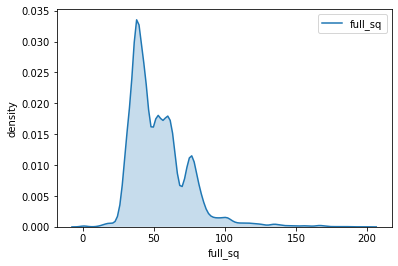

In [489]:
plot_feature_kde('full_sq', 0, 200)

In [490]:
train[train['build_year'] > 2018].shape[0]

2

In [491]:
# due to release date of the dataset
train.drop(train[train['build_year'] > 2018].index, inplace=True)

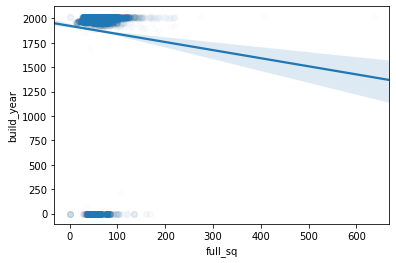

In [492]:
sns.regplot(x=train['full_sq'], y=train['build_year'], scatter_kws={'alpha':0.01})

We have a problem with build_year column to: few houses have an incorrect build_date

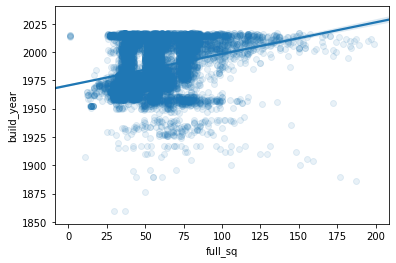

In [493]:
plot_regplot('full_sq', 'build_year', 1, 200, 1800, 2018)

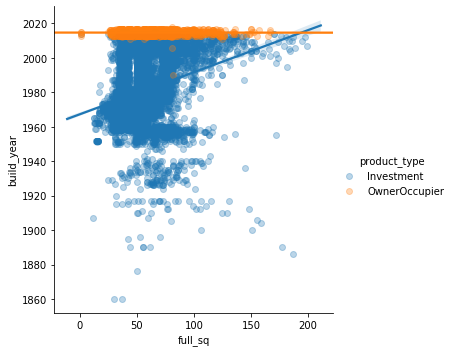

In [494]:
plot_lmplot('full_sq', 'build_year', 'product_type', 0, 200, 1800, 2018, alpha=0.3)

As we can see from here product_type == OwnerOccupier might mean that the house was built recently and product_type == Investment might mean that the house is already quite old.

In [495]:
train[(train['product_type'] == 'OwnerOccupier') & (train['build_year'] > 1800)].describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,2482.000000,1950.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2259.000000,2.482000e+03,...,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2.482000e+03
mean,59.744561,51.525128,9.221595,14.096696,2.191378,2014.693795,1.831185,6.328364,1.117751,2.674097e+07,...,39.618856,14.756648,2.660757,16.213135,31.617244,0.380338,10.432313,40.937953,3.922240,7.532435e+06
std,25.962116,171.066969,6.126245,7.748277,1.808451,1.185238,0.832692,57.633113,0.469003,2.852879e+07,...,98.787799,38.306992,7.221222,38.540944,62.813141,0.639604,27.818082,56.258316,4.618976,5.015339e+06
min,1.000000,0.000000,0.000000,0.000000,1.000000,1990.000000,0.000000,0.000000,1.000000,2.641243e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.016930e+05
25%,41.250000,34.000000,4.000000,9.000000,1.000000,2014.000000,1.000000,1.000000,1.000000,9.589337e+06,...,1.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,6.000000,0.000000,4.564326e+06
50%,57.000000,44.000000,8.000000,17.000000,1.000000,2015.000000,2.000000,1.000000,1.000000,1.258354e+07,...,2.000000,2.000000,0.000000,2.000000,10.000000,0.000000,0.000000,11.000000,1.000000,6.324151e+06
75%,74.000000,62.000000,13.000000,18.000000,4.000000,2015.000000,2.000000,10.000000,1.000000,3.574795e+07,...,13.000000,3.000000,1.000000,9.000000,23.000000,1.000000,4.000000,63.000000,6.000000,8.810103e+06
max,637.000000,7478.000000,37.000000,37.000000,6.000000,2018.000000,6.000000,2014.000000,4.000000,2.060718e+08,...,374.000000,141.000000,26.000000,150.000000,250.000000,2.000000,106.000000,203.000000,18.000000,7.124962e+07


In [496]:
train[(train['product_type'] == 'Investment') & (train['build_year'] > 1800)].describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,12290.000000,1.347800e+04,...,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,13478.000000,1.347800e+04
mean,52.029975,31.137335,6.733788,12.181481,1.877949,1979.970025,1.968393,7.979151,2.481286,1.113362e+07,...,33.718207,10.859994,1.720433,16.447025,32.788841,0.479967,9.193723,64.648390,7.628357,7.830377e+06
std,20.181182,15.498165,4.749766,5.591018,1.453752,18.106410,0.874500,18.044830,0.632236,1.031526e+07,...,64.361847,25.131222,4.885197,25.510535,41.228068,0.608130,17.850993,39.512227,4.464210,5.118174e+06
min,1.000000,0.000000,0.000000,0.000000,1.000000,1860.000000,0.000000,0.000000,1.000000,2.081628e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1967.000000,1.000000,6.000000,2.000000,5.686537e+06,...,6.000000,1.000000,0.000000,6.000000,12.000000,0.000000,1.000000,39.000000,4.000000,5.480000e+06
50%,46.000000,29.000000,5.000000,12.000000,1.000000,1976.000000,2.000000,8.000000,2.000000,8.568431e+06,...,11.000000,3.000000,0.000000,9.000000,22.000000,0.000000,3.000000,60.000000,7.000000,7.000000e+06
75%,60.000000,39.000000,9.000000,16.000000,2.000000,1995.000000,3.000000,9.000000,3.000000,1.249544e+07,...,28.000000,6.000000,1.000000,13.000000,31.000000,1.000000,8.000000,84.000000,11.000000,9.250000e+06
max,275.000000,458.000000,77.000000,57.000000,6.000000,2015.000000,19.000000,1974.000000,4.000000,2.060718e+08,...,376.000000,146.000000,29.000000,151.000000,249.000000,2.000000,105.000000,218.000000,21.000000,9.512250e+07


As we can see, the most of the houses were built between 1950 and early 2000's. Those houses mostely have full_sq between ~20 and 100 meters

In [497]:
for value in [10, 20, 30, 40, 50, 100, 150, 200, 250, 375, 500]:
    print(str(num_houses_with_bigger_column_value('full_sq', value)) + 
          ' houses have bigger full square than ' + str(value) + '.')

30438 houses have bigger full square than 10.
30304 houses have bigger full square than 20.
29359 houses have bigger full square than 30.
20875 houses have bigger full square than 40.
14839 houses have bigger full square than 50.
960 houses have bigger full square than 100.
169 houses have bigger full square than 150.
35 houses have bigger full square than 200.
15 houses have bigger full square than 250.
10 houses have bigger full square than 375.
5 houses have bigger full square than 500.


We have several houses with really big full_sq value (over 200 meters), it might be a good idea to separate them from all the other houses in the future.

In [498]:
train[train['full_sq'] < 1].iloc[:, :9]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq
id,,,,,,,,,
17935,2014-04-28,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24299,2014-11-05,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0


In [499]:
train.drop([17935], inplace=True)

It's not important for now to care about incorrect square cases: for example full_sq < life_sq - we'll do that later in this notebook.

Let's examine full_sq, life_sq and full_sq, kitch_sq pairs of columns closely

In [500]:
train[train['full_sq'] < train['life_sq']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1085,2012-02-06,44,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,6200000
1189,2012-02-14,9,44.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6,3,0,9,18,0,10,53,9,6300000
1825,2012-04-09,18,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,1,0,8,23,0,3,55,9,5200000
1866,2012-04-11,30,178.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,223,98,20,48,91,1,68,155,7,5900000
2012,2012-04-25,5,40.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6,2,0,10,14,0,2,50,5,5770000


In [501]:
train[train['full_sq'] < train['kitch_sq']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
8059,2013-05-21,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,...,339,135,26,133,207,1,89,161,10,2750000
9175,2013-07-12,37,19.0,9.0,10.0,1.0,2006.0,1.0,73.0,2.0,...,1,1,0,5,9,0,2,17,6,5600000
10371,2013-09-10,79,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,...,0,0,0,1,7,1,0,12,1,7281225
11523,2013-10-24,38,23.0,11.0,14.0,5.0,1971.0,2.0,620.0,2.0,...,4,2,0,7,16,0,9,49,11,6300000
12248,2013-11-18,22,14.0,3.0,5.0,2.0,1970.0,1.0,33.0,1.0,...,30,4,0,17,30,0,7,93,3,3600000


We will figure out how to swap full_sq, life_sq and kitch_sq values in each of those bad rows to make information about the house sensible.

/home/sergei/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


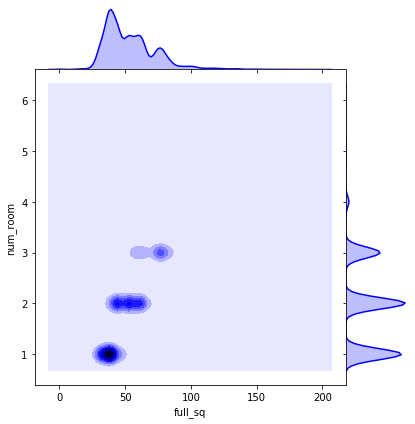

In [502]:
plot_features_jointplot('full_sq', 'num_room', 0, 200, 1, 6)

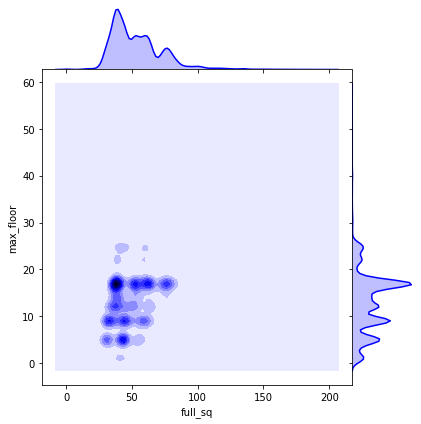

In [503]:
plot_features_jointplot('full_sq', 'max_floor', 0, 200, 1, 80)

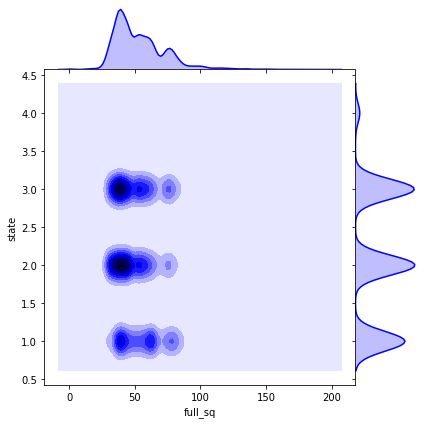

In [504]:
plot_features_jointplot('full_sq', 'state', 0, 200, 0, 10, alpha=0.3)

As we can see, full_sq doen't determine house's condition

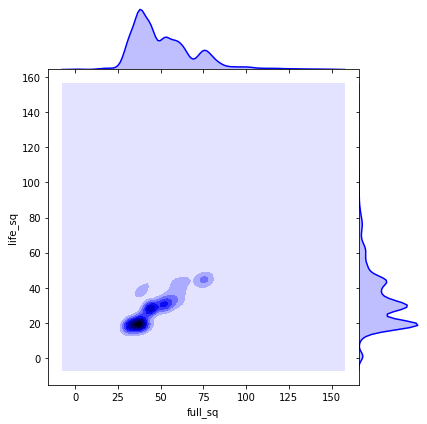

In [505]:
plot_features_jointplot('full_sq', 'life_sq', 0, 150, 0, 150)

## &emsp; life_sq

In [506]:
train['life_sq'].describe()

count    24084.000000
mean        34.406411
std         52.289367
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

In [507]:
'Number of houses with life square = 0, equals ' + str(len(train[train.life_sq == 0]))

'Number of houses with life square = 0, equals 44'

In [508]:
train[train.life_sq == 0].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
859,2012-01-19,78,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,5,6,0,0,11,2,552312
1599,2012-03-20,59,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,4,6,0,0,7,1,338570
2781,2012-07-06,38,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,4,6,0,0,10,1,675205
3429,2012-08-31,71,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,4,6,0,0,10,1,1438647
3803,2012-09-24,57,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,1,7,0,0,8,0,5049071


In [509]:
sample_data = train['life_sq'] / (train['full_sq'] + 1)
sample_data.mask(np.isinf(sample_data), inplace=True)
sample_data.dropna(inplace=True)
sample_data = sample_data.apply(lambda x: min(x, 1))
mean_division_value = sample_data[sample_data > 0.5].describe()['mean']
mean_division_value

0.6701783834921767

As we can see, the mean value for this column for a resonable house for this column should be around 0.67.

In [510]:
train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
train['life_sq/full_sq'].mask(np.isinf(train['life_sq/full_sq']), inplace=True)
train['life_sq/full_sq'].fillna(mean_division_value, inplace=True)

In [511]:
train['life_sq/full_sq'].describe()

count    30467.000000
mean         0.642431
std          0.777689
min          0.000000
25%          0.545455
50%          0.616667
75%          0.670178
max         93.475000
Name: life_sq/full_sq, dtype: float64

In [512]:
train[train['life_sq'] > 200].head(30)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq
id,,,,,,,,,,,,,,,,,,,,,
129,2011-10-15,325,325.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,7,14,0,9,44,10,5000000,0.996933
1085,2012-02-06,44,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,13,22,1,0,52,4,6200000,6.244444
4388,2012-10-25,73,426.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,8,0,14,25,0,3,88,14,11918400,5.756757
9240,2013-07-16,47,301.0,4.0,12.0,1.0,1973.0,2.0,6.0,2.0,...,1,0,5,13,0,2,30,5,5600000,6.270833
9259,2013-07-17,77,458.0,12.0,16.0,1.0,1996.0,3.0,10.0,3.0,...,0,0,5,22,0,0,18,7,13750000,5.871795
9649,2013-08-06,82,802.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,7,16,0,0,34,5,12031350,9.662651
13549,2013-12-30,79,7478.0,8.0,17.0,1.0,2014.0,3.0,1.0,1.0,...,0,0,1,7,1,0,12,1,7705000,93.475000
13632,2014-01-10,45,259.0,5.0,5.0,1.0,1970.0,2.0,5.0,NaN,...,0,0,1,7,0,0,8,0,4900000,5.630435
18528,2014-05-16,275,232.0,11.0,37.0,6.0,2009.0,5.0,26.0,1.0,...,5,1,8,19,0,3,74,11,15919294,0.840580


In [513]:
train.loc[train['life_sq'] > 200, 'life_sq'] = \
                                    train.loc[train['life_sq'] > 200, :].apply(lambda x: \
                                    x['full_sq'] - x['kitch_sq'] if x['kitch_sq'] >= 0 else x['full_sq'], axis=1)

In [514]:
train[train['life_sq'] > train['full_sq']].shape[0]

28

In [515]:
train[train['life_sq'] > train['full_sq']][['full_sq', 'life_sq', 'price_doc', 'life_sq/full_sq']]

,full_sq,life_sq,price_doc,life_sq/full_sq
id,,,,
1189,9,44.0,6300000,4.400000
1825,18,38.0,5200000,2.000000
1866,30,178.0,5900000,5.741935
2012,5,40.0,5770000,6.666667
6339,37,191.0,5400000,5.026316
6534,80,88.0,13801229,1.086420
6996,73,77.0,6290256,1.040541
7211,31,195.0,6400000,6.093750
8104,37,38.0,3622465,1.000000


There is definitely interconnection between life_sq/full_sq, full_sq, life_sq columns and the way we should decide wether real full_sq equals full_sq or life_sq.

In [516]:
def change_life_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1 / 0.67:
        return row['life_sq'] - row['full_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['full_sq']
    return row['life_sq']

def change_full_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1.3:
        return row['life_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['life_sq']
    return row['full_sq']

def account_kitch_sq (row):
    if row['kitch_sq'] >= 0 and row['kitch_sq'] < row['full_sq_help']:
        return row['full_sq_help'] - row['kitch_sq']
    return row['life_sq_help']

In [517]:
mean_value = train['life_sq/full_sq'].mean()
train['life_sq'] = train.apply(lambda x: x['life_sq'] if not pd.isnull(x['life_sq']) \
                               else x['full_sq'] * mean_value, axis=1)
train_help = train[['full_sq', 'life_sq', 'kitch_sq', 'life_sq/full_sq']].copy()
train_help['life_sq_help'] = train_help.apply(change_life_sq, axis=1)
train_help['full_sq_help'] = train_help.apply(change_full_sq, axis=1)
train_help['life_sq_help'] = train_help.apply(account_kitch_sq, axis=1)
train_help['life_sq_help'] = train_help.apply(lambda x: x['life_sq_help'] \
                                if not pd.isnull(x['life_sq_help']) else x['full_sq_help'] * mean_value, axis=1)

Let's examine the results

In [518]:
train_help[train_help['life_sq'] > train_help['full_sq']]

,full_sq,life_sq,kitch_sq,life_sq/full_sq,life_sq_help,full_sq_help
id,,,,,,
1189,9,44.0,NaN,4.400000,35.0,44.0
1825,18,38.0,NaN,2.000000,20.0,38.0
1866,30,178.0,NaN,5.741935,30.0,30.0
2012,5,40.0,NaN,6.666667,35.0,40.0
6339,37,191.0,NaN,5.026316,37.0,37.0
6534,80,88.0,NaN,1.086420,80.0,88.0
6996,73,77.0,NaN,1.040541,73.0,77.0
7211,31,195.0,NaN,6.093750,31.0,31.0
8104,37,38.0,NaN,1.000000,37.0,38.0


Let's make a dummy check

In [519]:
train_help[train_help['full_sq_help'] < train_help['life_sq_help']].shape[0]

0

In [520]:
train_help[(train_help['life_sq_help'].isnull())].shape[0]

0

In [521]:
train_help[train_help['life_sq_help'] < 0].shape[0]

0

in my opinion everything went quite well. This funtion will be included in the final Pipeline.

In [522]:
train[['full_sq', 'life_sq']] = train_help[['full_sq_help', 'life_sq_help']]

Let's recalculate new life_sq/full_sq and back_life_sq_ratio.

In [523]:
train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
train['back_life_sq_ratio'] = 1 / train['life_sq/full_sq']

In [524]:
train['life_sq/full_sq'].describe()

count    30467.000000
mean         0.792151
std          0.152564
min          0.000000
25%          0.651893
50%          0.823529
75%          0.906723
max          0.998425
Name: life_sq/full_sq, dtype: float64

In [525]:
train[train['life_sq/full_sq'] > 0.9].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,
5,2011-09-05,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,17,135,236,2,91,195,14,16331452,0.987179,1.012987
8,2011-09-09,44.0,44.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,11,18,1,0,47,4,2000000,0.977778,1.022727
14,2011-09-19,31.0,31.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,22,57,102,1,72,166,7,5200000,0.968750,1.032258
22,2011-09-22,39.0,39.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,12,14,0,1,64,9,5200000,0.975000,1.025641
38,2011-09-30,27.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,20,1,3,53,9,4300000,0.964286,1.037037


In [526]:
train[~(train['full_sq'] == train['life_sq'] + train['kitch_sq']) & (~pd.isnull(train['kitch_sq']))].head(10)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,
8059,2013-05-21,11.0,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,...,26,133,207,1,89,161,10,2750000,0.916667,1.090909
8952,2013-07-04,123.0,123.0,3.0,10.0,2.0,2013.0,3.0,123.0,3.0,...,0,0,10,0,0,2,0,8287230,0.991935,1.008130
9175,2013-07-12,37.0,19.0,9.0,10.0,1.0,2006.0,1.0,73.0,2.0,...,0,5,9,0,2,17,6,5600000,0.500000,2.000000
10190,2013-08-30,54.0,54.0,25.0,25.0,6.0,2015.0,2.0,54.0,1.0,...,1,5,4,0,1,32,5,8552548,0.981818,1.018519
10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,...,0,1,7,1,0,12,1,7281225,0.512500,1.951220
10644,2013-09-21,41.0,1.0,2.0,1.0,6.0,NaN,1.0,41.0,1.0,...,2,3,17,0,0,51,3,7529400,0.023810,42.000000
10683,2013-09-24,41.0,41.0,10.0,19.0,4.0,2014.0,1.0,41.0,3.0,...,0,7,16,0,0,34,5,6692335,0.976190,1.024390
10731,2013-09-25,63.0,30.0,16.0,16.0,4.0,NaN,2.0,63.0,NaN,...,0,1,7,1,0,12,1,5813760,0.468750,2.133333
11190,2013-10-11,58.0,1.0,13.0,22.0,6.0,NaN,2.0,58.0,1.0,...,1,5,4,0,1,32,5,9069927,0.016949,59.000000


These kitch_sq fields are irrelevant and we need to get rid of them.

In [527]:
train.loc[train['life_sq/full_sq'] > 0.9, 'life_sq'] = \
                    train.loc[train['life_sq/full_sq'] > 0.9].apply(lambda x: x['full_sq'] * mean_value, axis=1)

In [528]:
import math

train.loc[:, 'life_sq'] = train.apply(lambda x: math.ceil(x['life_sq']), axis=1)

In [529]:
train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
train['full_sq/life_sq'] = 1 / train['life_sq/full_sq']

## &emsp; kitch_sq

In [530]:
train['kitch_sq'].describe()

count    20896.000000
mean         6.399550
std         28.267966
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: kitch_sq, dtype: float64

As we can see, there are some houses with extremely big kitch_sq value, lets count those houses.

In [531]:
for value in [10, 20, 30, 40, 50, 60, 80, 100, 150, 200]:
    print(str(num_houses_with_bigger_column_value('kitch_sq', value)) + 
          ' houses have bigger kitch square than ' + str(value) + '.')

1637 houses have bigger kitch square than 10.
111 houses have bigger kitch square than 20.
75 houses have bigger kitch square than 30.
53 houses have bigger kitch square than 40.
41 houses have bigger kitch square than 50.
29 houses have bigger kitch square than 60.
14 houses have bigger kitch square than 80.
9 houses have bigger kitch square than 100.
5 houses have bigger kitch square than 150.
5 houses have bigger kitch square than 200.


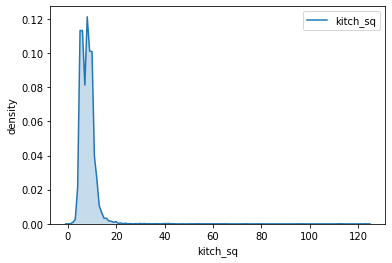

In [532]:
plot_feature_kde('kitch_sq', 1, 150)

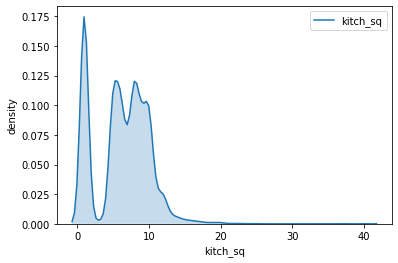

In [533]:
plot_feature_kde('kitch_sq', 1, 40)

In [534]:
train[train['kitch_sq'] > 100]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,full_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
8952,2013-07-04,123.0,80,3.0,10.0,2.0,2013.0,3.0,123.0,3.0,...,0,10,0,0,2,0,8287230,0.645161,1.008130,1.550000
10371,2013-09-10,79.0,41,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,...,1,7,1,0,12,1,7281225,0.512500,1.951220,1.951220
11523,2013-10-24,38.0,23,11.0,14.0,5.0,1971.0,2.0,620.0,2.0,...,7,16,0,9,49,11,6300000,0.589744,1.695652,1.695652
13120,2013-12-14,31.0,19,5.0,1.0,1.0,NaN,1.0,1970.0,3.0,...,27,44,0,12,117,12,3650000,0.593750,1.684211,1.684211
20056,2014-06-24,112.0,72,3.0,3.0,1.0,2015.0,3.0,112.0,3.0,...,2,11,0,0,6,3,8200031,0.637168,1.008929,1.569444
21418,2014-08-11,43.0,28,3.0,1.0,1.0,2014.0,1.0,2014.0,1.0,...,0,12,1,0,6,1,3801200,0.636364,1.023256,1.571429
27934,2015-02-16,112.0,72,3.0,3.0,1.0,2015.0,3.0,112.0,3.0,...,2,11,0,0,6,3,10950065,0.637168,1.008929,1.569444
27999,2015-02-19,112.0,72,3.0,3.0,1.0,2015.0,3.0,112.0,3.0,...,10,9,0,0,38,4,10500000,0.637168,1.008929,1.569444
28737,2015-03-31,31.0,16,2.0,12.0,5.0,1972.0,1.0,1974.0,3.0,...,1,2,0,2,7,2,1000000,0.500000,2.000000,2.000000


As we can see, all of those houses have incorrect kitch_sq. We can calculate their kitch_sq = full_sq - life_sq. Since we've already correctly calculated life_sq, we can calculate kitch_sq.

In [535]:
train['kitch_sq'] = train.apply(lambda x: x['full_sq'] - x['life_sq'] , axis = 1)

In [536]:
train['life_sq/kitch_sq'] = (train['life_sq']) / (train['kitch_sq'] + 1)

In [537]:
train[['full_sq', 'life_sq', 'kitch_sq']].isna().sum()

full_sq     0
life_sq     0
kitch_sq    0
dtype: int64

In [538]:
train[['life_sq/full_sq', 'full_sq/life_sq', 'life_sq/kitch_sq']].isna().sum()

life_sq/full_sq     0
full_sq/life_sq     0
life_sq/kitch_sq    0
dtype: int64

As we can see verithing went well.

In [539]:
print(len(train[train['kitch_sq'] > train['life_sq']].index), 'houses have kitch_sq > life_sq.')

784 houses have kitch_sq > life_sq.


In [540]:
train[train['kitch_sq'] > train['life_sq']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,full_sq/life_sq,life_sq/kitch_sq
id,,,,,,,,,,,,,,,,,,,,,
35,2011-09-28,39.0,19,1.0,NaN,NaN,NaN,NaN,20.0,NaN,...,3,0,2,8,2,3900000,0.475000,2.105263,2.105263,0.904762
72,2011-10-05,64.0,28,10.0,NaN,NaN,NaN,NaN,36.0,NaN,...,16,0,4,46,5,2630000,0.430769,2.321429,2.321429,0.756757
73,2011-10-06,66.0,17,2.0,NaN,NaN,NaN,NaN,49.0,NaN,...,200,2,69,166,16,2600000,0.253731,3.941176,3.941176,0.340000
80,2011-10-07,133.0,64,2.0,NaN,NaN,NaN,NaN,69.0,NaN,...,17,0,3,54,7,17600000,0.477612,2.093750,2.093750,0.914286
86,2011-10-07,43.0,21,7.0,NaN,NaN,NaN,NaN,22.0,NaN,...,18,2,3,71,4,6700000,0.477273,2.095238,2.095238,0.913043


In my opinion, I can't imagine a real house with kitch_sq much bigger than life_sq. We'll see how we can swap kitch_sq and life_sq according to life_sq/kitch_sq ratio.

In [541]:
train[train['life_sq/kitch_sq'] < 0.8].shape[0]

415

In [542]:
train[train['life_sq/kitch_sq'] < 0.8].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,full_sq/life_sq,life_sq/kitch_sq
id,,,,,,,,,,,,,,,,,,,,,
72,2011-10-05,64.0,28,10.0,NaN,NaN,NaN,NaN,36.0,NaN,...,16,0,4,46,5,2630000,0.430769,2.321429,2.321429,0.756757
73,2011-10-06,66.0,17,2.0,NaN,NaN,NaN,NaN,49.0,NaN,...,200,2,69,166,16,2600000,0.253731,3.941176,3.941176,0.340000
102,2011-10-12,37.0,16,9.0,NaN,NaN,NaN,NaN,21.0,NaN,...,170,2,81,168,7,8600000,0.421053,2.375000,2.375000,0.727273
105,2011-10-13,26.0,1,6.0,NaN,NaN,NaN,NaN,25.0,NaN,...,33,1,3,72,12,4146000,0.037037,27.000000,27.000000,0.038462
202,2011-10-25,33.0,14,8.0,NaN,NaN,NaN,NaN,19.0,NaN,...,8,1,0,20,2,5700000,0.411765,2.428571,2.428571,0.700000


In [543]:
train_help = train[['kitch_sq', 'life_sq', 'full_sq', 'life_sq/kitch_sq', 'num_room']].copy()
train_help['life_sq_help'] = train_help.apply(lambda x: x['kitch_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['life_sq'], axis=1)
train_help['kitch_sq_help'] = train_help.apply(lambda x: x['life_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['kitch_sq'], axis=1)
train[['life_sq', 'kitch_sq']]= train_help[['life_sq_help', 'kitch_sq_help']]

Let's check that we've done everything correctly: there are no NANs in the full_sq, life_sq and kitch_sq columns.

In [544]:
train[['full_sq', 'life_sq', 'kitch_sq']].isna().sum()

full_sq     0
life_sq     0
kitch_sq    0
dtype: int64

In [545]:
train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
train['life_sq/kitch_sq'] = train['life_sq'] / (train['kitch_sq'] + 1)
train['full_sq/life_sq'] = 1 / train['life_sq/full_sq']
train['kitch_sq/life_sq'] = 1 / train['life_sq/kitch_sq'] 

Let's examine life_sq and kitch_sq distributions now when we've filled in NANs and swaped some values. 

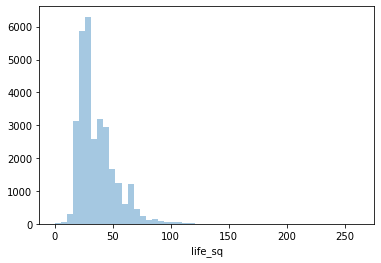

In [546]:
  plot_distplot('life_sq')

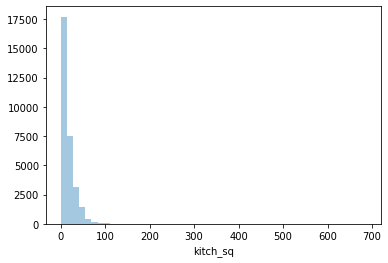

In [547]:
plot_distplot('kitch_sq')

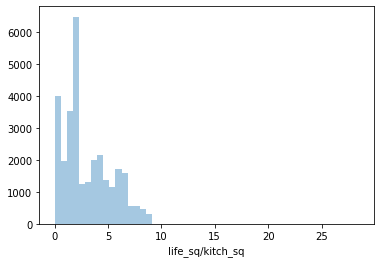

In [548]:
plot_distplot('life_sq/kitch_sq')

As we can see, we still have lots of houses with kitch_sq around zero.

In [549]:
print(len(train[train['kitch_sq'] < 5]), 'houses have kitch_sq less than 5 meters.')

243 houses have kitch_sq less than 5 meters.


In [550]:
print(len(train[train['kitch_sq'] < 1]), 'houses have kitch_sq less than 1 meter.')

0 houses have kitch_sq less than 1 meter.


In [551]:
train[train['kitch_sq'] < 1].shape[0]

0

Let's examine kitch_sq and life_sq / kitch_sq median.

In [552]:
train['kitch_sq'].mean()

17.73663307841271

In [553]:
train['life_sq/kitch_sq'].median()

1.8571428571428572

In [554]:
train['life_sq/kitch_sq'].describe()

count    30467.000000
mean         3.064779
std          2.219972
min          0.000000
25%          1.428571
50%          1.857143
75%          4.625000
max         28.500000
Name: life_sq/kitch_sq, dtype: float64

In [555]:
train['life_sq/full_sq'].describe()

count    30467.000000
mean         0.670894
std          0.173094
min          0.000000
25%          0.588235
50%          0.650000
75%          0.822222
max          0.966102
Name: life_sq/full_sq, dtype: float64

In [556]:
train['life_sq/full_sq'].mean()

0.6708936493818983

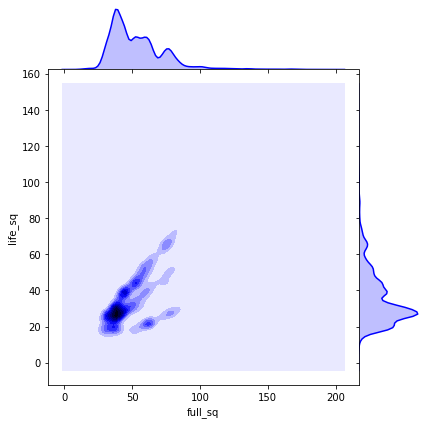

In [557]:
plot_features_jointplot('full_sq', 'life_sq', 1, 200, 1, 150)

In [560]:
train.rename(columns={'kitch_sq' : 'other_sq'}, inplace=True)

In [561]:
train.loc[:, 'full_sq'] = train.apply(lambda x: round(x['full_sq']), axis=1)
train.loc[:, 'life_sq'] = train.apply(lambda x: round(x['life_sq']), axis=1)
train.loc[:, 'other_sq'] = train.apply(lambda x: round(x['other_sq']), axis=1)